# 02 Model Building and Training

This notebook covers Task 2: building and evaluating fraud detection models for both e-commerce and credit card transaction data. We compare Logistic Regression (baseline) and XGBoost (ensemble) using metrics suitable for imbalanced data.

## 1. Setup and Imports

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.pardir)))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (
    confusion_matrix, f1_score, precision_recall_curve, auc, classification_report
)
from IPython.display import display

%matplotlib inline

## 2. Load Configuration and Data

In [2]:
# Load config
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Load processed data
fraud_train = pd.read_csv(config['data']['processed']['fraud_train_smote'])
fraud_train_labels = pd.read_csv(config['data']['processed']['fraud_train_labels_smote'])
fraud_test = pd.read_csv(config['data']['processed']['fraud_test'])
fraud_test_labels = pd.read_csv(config['data']['processed']['fraud_test_labels'])

credit_train = pd.read_csv(config['data']['processed']['credit_train_smote'])
credit_train_labels = pd.read_csv(config['data']['processed']['credit_train_labels_smote'])
credit_test = pd.read_csv(config['data']['processed']['credit_test'])
credit_test_labels = pd.read_csv(config['data']['processed']['credit_test_labels'])


## 3. Helper Functions: Evaluation and Plotting

In [3]:
def evaluate_model(y_true, y_pred, y_proba, average='binary', pos_label=1):
    cm = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average=average, pos_label=pos_label)
    precision, recall, _ = precision_recall_curve(y_true, y_proba, pos_label=pos_label)
    auc_pr = auc(recall, precision)
    print('Confusion Matrix:')
    print(cm)
    print('F1 Score:', f1)
    print('AUC-PR:', auc_pr)
    print('Classification Report:')
    print(classification_report(y_true, y_pred))
    plt.figure(figsize=(6,4))
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()
    return {'confusion_matrix': cm, 'f1': f1, 'auc_pr': auc_pr}


## 4. Model Training and Evaluation: Fraud Data (E-commerce)

--- Logistic Regression (Fraud Data) ---
Confusion Matrix:
[[22443   933]
 [  852  1602]]
F1 Score: 0.6422128683102826
AUC-PR: 0.6709501223196818
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     23376
           1       0.63      0.65      0.64      2454

    accuracy                           0.93     25830
   macro avg       0.80      0.81      0.80     25830
weighted avg       0.93      0.93      0.93     25830



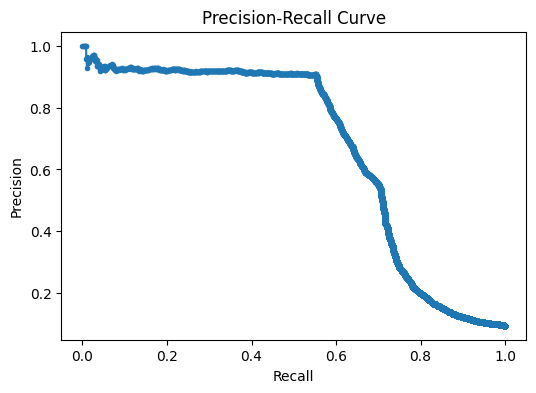

d:\Projects\Python\fraud-detection\fraud_detection_project\.venv311\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:57:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


--- XGBoost (Fraud Data) ---
Confusion Matrix:
[[23340    36]
 [ 1087  1367]]
F1 Score: 0.7088410681877106
AUC-PR: 0.7203784071063137
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     23376
           1       0.97      0.56      0.71      2454

    accuracy                           0.96     25830
   macro avg       0.96      0.78      0.84     25830
weighted avg       0.96      0.96      0.95     25830



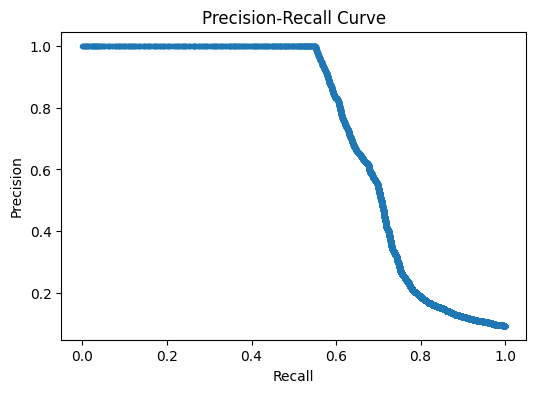

In [4]:
# Separate features and target
X_fraud_train = fraud_train
y_fraud_train = fraud_train_labels['class']
X_fraud_test = fraud_test
y_fraud_test = fraud_test_labels['class']

# Logistic Regression
lr_fraud = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_fraud.fit(X_fraud_train, y_fraud_train)
y_pred_lr = lr_fraud.predict(X_fraud_test)
y_proba_lr = lr_fraud.predict_proba(X_fraud_test)[:,1]
print('--- Logistic Regression (Fraud Data) ---')
metrics_lr_fraud = evaluate_model(y_fraud_test, y_pred_lr, y_proba_lr)

# XGBoost
xgb_fraud = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=1, random_state=42)
xgb_fraud.fit(X_fraud_train, y_fraud_train)
y_pred_xgb = xgb_fraud.predict(X_fraud_test)
y_proba_xgb = xgb_fraud.predict_proba(X_fraud_test)[:,1]
print('--- XGBoost (Fraud Data) ---')
metrics_xgb_fraud = evaluate_model(y_fraud_test, y_pred_xgb, y_proba_xgb)


## 5. Model Training and Evaluation: Credit Card Data

--- Logistic Regression (Credit Card Data) ---
Confusion Matrix:
[[55169  1482]
 [   12    83]]
F1 Score: 0.1
AUC-PR: 0.7128769744498685
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56651
           1       0.05      0.87      0.10        95

    accuracy                           0.97     56746
   macro avg       0.53      0.92      0.54     56746
weighted avg       1.00      0.97      0.99     56746



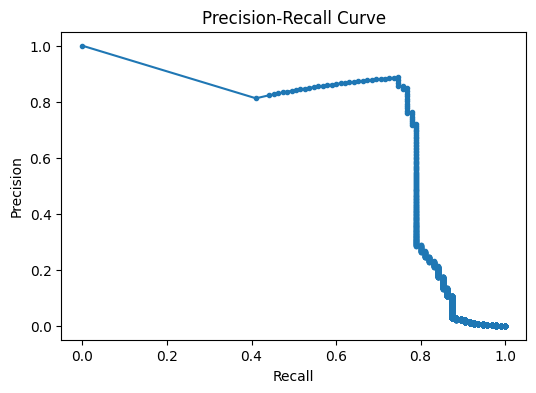

d:\Projects\Python\fraud-detection\fraud_detection_project\.venv311\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:58:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


--- XGBoost (Credit Card Data) ---
Confusion Matrix:
[[56623    28]
 [   20    75]]
F1 Score: 0.7575757575757576
AUC-PR: 0.8081104649149282
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.73      0.79      0.76        95

    accuracy                           1.00     56746
   macro avg       0.86      0.89      0.88     56746
weighted avg       1.00      1.00      1.00     56746



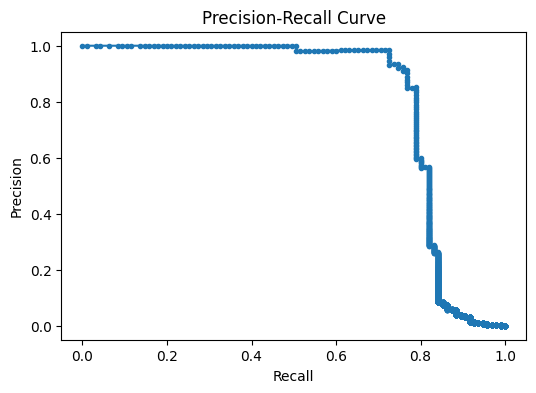

In [5]:
# Separate features and target
X_credit_train = credit_train
y_credit_train = credit_train_labels['Class']
X_credit_test = credit_test
y_credit_test = credit_test_labels['Class']

# Logistic Regression
lr_credit = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_credit.fit(X_credit_train, y_credit_train)
y_pred_lr_c = lr_credit.predict(X_credit_test)
y_proba_lr_c = lr_credit.predict_proba(X_credit_test)[:,1]
print('--- Logistic Regression (Credit Card Data) ---')
metrics_lr_credit = evaluate_model(y_credit_test, y_pred_lr_c, y_proba_lr_c)

# XGBoost
xgb_credit = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=1, random_state=42)
xgb_credit.fit(X_credit_train, y_credit_train)
y_pred_xgb_c = xgb_credit.predict(X_credit_test)
y_proba_xgb_c = xgb_credit.predict_proba(X_credit_test)[:,1]
print('--- XGBoost (Credit Card Data) ---')
metrics_xgb_credit = evaluate_model(y_credit_test, y_pred_xgb_c, y_proba_xgb_c)


## 6. Model Comparison and Justification

Summarize and compare the results of both models on both datasets. Discuss which model performed best and why, considering both metrics and business context.